<div>
<img src="https://csdms.colorado.edu/csdms_wiki/images/ESPIn-mtns-skinny-transparent.png" width="800"/>
</div>

<div>
<img src="https://csdms.colorado.edu/csdms_wiki/images/thumb/CSDMS-logo-color-notagline-ver_high.png/400px-CSDMS-logo-color-notagline-ver_high.png" width="200" hspace="20"><a href="http://landlab.github.io"><img src="https://raw.githubusercontent.com/landlab/tutorials/release/landlab_header.png" width="500"></a>
</div>

# Post-Glacial Landscape Lab: Exploring the Dynamic Environments of Glacial Retreat 
<div>
<img src="KviarjokullOblique.jpg" width="600" hspace="20">
</div>
Kviarjokull System in Southeast Iceland

### Overview
This lab will introduce some of the key drivers of landscape change following deglaciation. It will walk the reader through the application of several components of the Landlab modeling ecosystem relevant to the system. The lab will develop familiarity with modeling 2D systems, including setting up gridded topography with subsurface ice (RasterModelGrid), and employing physics-based landscape modification components (LinearDiffuser, OverlandFlow, FlowDirectorSteepest, FlowAccumulator, SedDepEroder, ChannelProfiler, PriorityFloodFlowRouter, DepressionFinderAndRouter, Space). The final componant of the lab will be to simulate flow over real topography for the KviarJokull proglacial system in Southern Iceland, where Icelend's main cross country road crosses just at the foot.

### Time: 1-2 hrs

### Learning objectives
#### Skills
Running 2D numerical models in Landlab to simulate short term landscape evolution applicable to rapidly warming Arctic and alpine Environments.

#### Key concepts

* Paraglacial and periglacial processes
* Predicting outflow, erosion, sediment flux and vegetation dynamics of a deglaciated setting.

### Requirements
If you don't already have a JupyterHub account, follow the instructions to sign up at https://csdms.colorado.edu/wiki/JupyterHub. If you're an educator, you can get JupyterHub accounts for students--please contact us through the CSDMS Help Desk: https://csdms.github.io/help-desk.

If run locally, first download all the files from this repository and have conda installed on the local PC. Then, use the following commands to create a virtual environment and launch the Jupyter Notebook.

    $ cd 2025-postglacial-landscapes
    $ conda env create --file=environment.yml
    $ conda activate ivy
    $ jupyter notebook


### Contributors 
* Viet M Bui (organic rice fed - Delta & SLR dude)
* Ari Koeppel (sol3ling)
* Shayla Triantafillou (river gal)
* Karin Lehnigk (glof club)
* Lucille Baker-Stahl (temperature + morphodynamics = ?)
* Tom Hoseason (tbd)

This lab was developed as part of the 2025 Earth Surface Processeses Institute (ESPIn) with support from the National Science Foundation under collaborative grants 1831623, 2026951, 2140831, 2104102, and 2148762.

# Table of Contents
* [Introduction](#Introduction)
Overview of relevance of lab to natural systems.

* [Step I. Setting up a Moraine Diffusion Model](#step-i-setting-up-a-moraine-diffusion-model)
See how simple manipulations affect erosion of permafrost and ice-cored sediment.

* [Step II. Setting up an Overland Flow Model](#step-ii-setting-up-an-overland-flow-model)
Practice building a function to model the effects of overland flow.

* [Step III. Sediment Transport](#step-iii-sediment-transport-coupling-diffusion-and-flow)
Practice building a function to model how sediment is transported in post-glacial systems.

* [Step IV. Vegetation and Erodibility](#step-iv-vegetation-and-erodibility)
Observe the dynamics of slope vegetation succession and how it evolves with erosive forces.

* [Step V. Combining the Elements](#step-v-combining-the-elements-into-a-scaled-model)
Combine all the elements together to track the landscape evolution of a postglacial system. This is first done over a synthetic landscape, and then over actual topographic data.

* [Summary and implications for our warming Arctic and alpine](#Summary)
Summary of the applicability and limitations of using a model like this.

## Introduction

Studying the dynamics of ice-cored moraines is essential for understanding how postglacial landscapes evolve. These landforms trap and slowly release glacial ice beneath a cover of sediment, which affects rates of meltwater production and sediment transport. As ice cores degrade, they can generate localized subsidence, alter drainage patterns, and increase sediment input into downstream channels. By measuring changes in surface morphology, ice volume, and melt rates, researchers can quantify sediment budgets and model the long-term development of glacial forefields, improving predictions of landscape adjustment following glacier retreat. 

Beyond landscape evolution, ice-cored moraine dynamics pose direct implications for hazard assessment and water resources. Rapid collapse of moraine ridges or sudden outbursts of trapped meltwater may trigger debris flows, floods, and infrastructure damage in downstream communities. Conversely, the slow release of water from buried ice contributes to seasonal streamflow, particularly in regions dependent on glacial melt for irrigation and hydropower. Detailed monitoring and numerical modeling of ice-cored moraines thus support both risk mitigation—through early warning of potential slope failures—and resource management under changing climate conditions. 

In [21]:
# packages for the model
from landlab.components import (
    LinearDiffuser, OverlandFlow, FlowDirectorSteepest, FlowAccumulator, 
    SedDepEroder, ChannelProfiler, PriorityFloodFlowRouter, DepressionFinderAndRouter, Space
)
import numpy as np
import matplotlib.pyplot as plt
from landlab import RasterModelGrid, imshow_grid
from landlab.plot.graph import plot_graph
import matplotlib.pyplot as plt
from matplotlib import cm
import math
import pandas as pd

## Step I. Setting up a Moraine Diffusion Model

### Generate Synthetic Idealized Moraine Topography
To model a erosional postglacial system, a key element is the presence of subsurface ice. Here, three layers are defined: Soil thickness, ice thickness, and a bottom bedrock surface.

In [ ]:
## Define the grid
size_x = 100
size_y = 200
spacing = 1.0
grid = RasterModelGrid((size_y, size_x), xy_spacing=spacing)

# morph the grid with a sine function
ice_height = 10 # meters
bedrock_slope = 0.22 # radians
soil_thickness = 5 # meters **PLAY WITH THIS**
moraine_disappears_at_y = 100 # meters

# add the topography    
z_ice = grid.add_zeros('ice__elevation', at='node')
z_soil = grid.add_zeros('soil__depth', at='node')
z_bed = grid.add_zeros('bedrock__elevation', at='node')
grid.add_zeros('topographic__elevation', at='node')

#base_soil_depth = 1  # meters
grid.at_node["soil__depth"][:] = soil_thickness

x = grid.x_of_node
y = grid.y_of_node

# setting ice elevation respected to the base elevation
z = ice_height * np.sin(np.pi*x / (size_x/3)) 
# get z where y is less than moraine_disappears_at_y
z[y<moraine_disappears_at_y] += (y[y<moraine_disappears_at_y] - moraine_disappears_at_y) * ice_height/moraine_disappears_at_y
z[z<0] = 0 # cut the sine function at 0

z_ice += z
z_soil += soil_thickness
z_bed += bedrock_slope * y

# reassign the values to the grid just to be sure
grid.at_node['ice__elevation'] = z_ice
grid.at_node['soil__depth'][:] = z_soil
grid.at_node['bedrock__elevation'] = z_bed + grid.at_node['ice__elevation']
grid.at_node['topographic__elevation'][:] = grid.at_node['bedrock__elevation'] + grid.at_node['soil__depth']

# add boundaries
grid.status_at_node[grid.nodes_at_left_edge] = grid.BC_NODE_IS_CLOSED
grid.status_at_node[grid.nodes_at_right_edge] = grid.BC_NODE_IS_CLOSED
# grid.status_at_node[grid.nodes_at_bottom_edge] = grid.BC_NODE_IS_CLOSED
grid.status_at_node[grid.nodes_at_top_edge] = grid.BC_NODE_IS_CLOSED

### Visualization of each layer

Individual layers are plotted in 3D, demonstrating how together they sum to create surface topography.

In [ ]:
fig, axs = plt.subplots(2, 2, subplot_kw={"projection": "3d"}, figsize=(12, 10))

def plot_each_axs(axs,size_x,size_y,topo, title="Topography"):
    X, Y = np.meshgrid(np.arange(0,size_x,spacing),np.arange(0,size_y,spacing))
    Z = topo.reshape(size_y, size_x)
    axs.set_box_aspect((1, size_y/size_x, Z.max()/size_x))
    axs.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    axs.set_title(title)
    cbar = fig.colorbar(axs.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False), ax=axs, shrink=0.5, aspect=10)

# Plot Ice Thickness
plot_each_axs(axs[0, 0], size_x, size_y, grid.at_node['ice__elevation'], title="Ice Thickness")

# Plot Soil Thickness
plot_each_axs(axs[0, 1], size_x, size_y, grid.at_node['soil__depth'], title="Soil Thickness")

# Plot Bedrock Layer
plot_each_axs(axs[1, 0], size_x, size_y, grid.at_node['bedrock__elevation'], title="Bedrock Layer (assuming ice layer is also bedrock)")

# Plot Topography
plot_each_axs(axs[1, 1], size_x, size_y, grid.at_node['topographic__elevation'], title="Topography")

# Adjust layout
plt.tight_layout()
plt.show()

### Define a Method That Thaws Ice as a Function of Overlying Sediment Thickness
Following the data from Østrem (1959) and Nicholson and Benn (2006), a function is included to thaw massive ground ice. At sediment thicknesses below 5 cm, ice thaws at a rate of 6 cm/day. When sediment thickness exceeds 52 cm, thaw is fully inhibited.

In [9]:
class ThawIce:
    #define function and input
    def __init__ (self, ice_thickness, soil_thickness, thaw_days_per_year, timestep_years):
        self.ice_thickness = ice_thickness 
        self.soil_thickness = soil_thickness
        self.thaw_days = thaw_days_per_year
        self.dt = timestep_years
    #define thaw function and inputs (dt is number of days
    def calc_thaw_rate(self):
        thaw_rate = []
        for i in range(len(self.soil_thickness)):
            if self.soil_thickness[i] <= 0.05: #m
                thaw_rate.append(self.thaw_days * 0.06) #m/yr
            elif  0.05 < self.soil_thickness[i] < .517:
                thaw_rate.append(0.0857*self.soil_thickness[i]*self.thaw_days)
            elif self.soil_thickness[i] >= .517:
                thaw_rate.append(0)
        self.thaw_rate = np.array(thaw_rate)
    def thaw(self):
         for i in range(len(self.ice_thickness)):
             if self.ice_thickness[i] >= self.thaw_rate[i]*self.dt:
                self.ice_thickness[i] = self.ice_thickness[i] - self.dt*self.thaw_rate[i]
             else:
                self.ice_thickness[i] = 0

days = 100 # Number of days per a year that thaw occurs
dt = 1 # Timestep in years

melt = ThawIce(ice_thickness = z_ice, soil_thickness = z_soil, thaw_days_per_year = days, timestep_years = dt)

#### Show landscape before and after XXX years of thaw

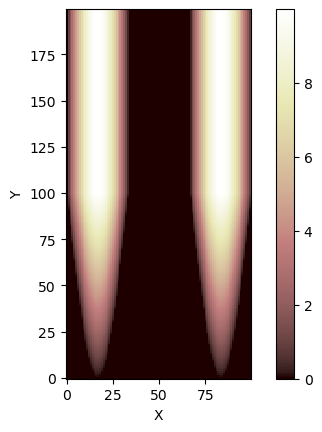

In [10]:
melt.calc_thaw_rate()
melt.thaw()

imshow_grid(grid, melt.ice_thickness)

## Step II. Setting up an Overland Flow Model

Newly exposed surfaces in proglacial basins often experience overland flow as well-defined channels have yet to form. This section explores where flow is likely to occur through time. Ulitmately, this section defines the water source for fluvial tansport in the next section.

#### Make necessary adjustments to grid to facilitate flow

In [ ]:
# set constant random seed for consistent topographic roughness
np.random.seed(seed=5000)

# impose topography values on model grid
grid.at_node['topographic__elevation'] += np.random.uniform(0.0, 1.0, size=grid.at_node['topographic__elevation'].shape)
# add boundaries for the ridge of the moraine
grid.status_at_node[grid.x_of_node < (100/6)] = grid.BC_NODE_IS_CLOSED
grid.status_at_node[grid.x_of_node > (100-100/6)] = grid.BC_NODE_IS_CLOSED

# Set lower-edge as an open boundary
grid.set_watershed_boundary_condition_outlet_id(
    50 , grid.at_node["topographic__elevation"], -9999.0
)

#### Assign key parameters

In [ ]:
# ChannelProfiler parameters
number_of_watersheds = 1
minimum_channel_threshold=100
# PriorityFloodFLowRouter parameters
flow_metric = "D8"
phi_FR = 0.0
debris_thickness_rate = 0.08 # m/yr
# OVERLAND FLOW parameters
# We establish the channel width & upstream position on the grid
channel_w = 20. # set channel width, meters (PLAY WITH THIS VALUE!!)
channel_center = size_x/(2 * spacing)
# print(channel_center)
channel_diff = channel_w/2


num_nodes = size_x * size_y / spacing - 1
node_channel_left = int(num_nodes - channel_center - channel_diff)-size_x
node_channel_right = int(num_nodes - channel_center + channel_diff)-size_x

# We set fixed boundary conditions, specifying the nodes and links in which the water is flowing into the grid
inlet_nodes = np.arange(math.floor(node_channel_left), math.ceil(node_channel_right), spacing).astype(int)

# We set the fixed values in the entry nodes/links
constant_Q = 10000. # discharge value; m3/s (PLAY WITH THIS VALUE!!)
Q_array = np.ones(len(inlet_nodes)) * constant_Q

# We establish the initial conditions for depth (empty)
h = grid.add_zeros("surface_water__depth", at="node", clobber=True)

# Water velocity is zero in everywhere since there is no water yet
vel = grid.add_zeros("surface_water__velocity", at="link", clobber=True)

# Calculating the initial water surface elevation from water depth and topographic elevation
wse = grid.add_field("surface_water__elevation", grid.at_node['topographic__elevation'], at="node", clobber=True)

# We set some other values
mannings_n = 0.05 # Mannings roughness
# dt = 50 # Timestep; this is probably defined above/elsewhere

#### Set up modeling elements

In [15]:
# Instantiate the OverlandFlow component to work on this grid and run it
of = OverlandFlow(grid, steep_slopes=True)

# Instantiate the ThawIce component to work on this grid and run it
# ti = ThawIce(ice_thickness=grid.at_node['ice__elevation'])

# Instantiate flow router
fr = FlowAccumulator(grid, flow_director="FlowDirectorD8")

# Instantiate depression finder and router; optional
df = DepressionFinderAndRouter(grid)

# Instantiate SPACE model with chosen parameters
sp = Space(
    grid,
    K_sed=0.01, # Sediment erodibility, Governs the rate of sediment entrainment; may be specified as a single floating point number, an array of length equal to the number of grid nodes, or a string naming an existing grid field.
    K_br=0.00001, # Bedrock erodibility, Governs the rate of bedrock erosion; may be specified as a single floating point number, an array of length equal to the number of grid nodes, or a string naming an existing grid field.
    F_f=0.0, # Fraction of fine sediment, (unitless, 0-1) fraction of rock that does not get converted to sediment but assumed to exit model domain as wash load
    phi=0.0, # Sediment porosity
    H_star=1.0, # Sediment entrainment length scale - think of reflecting bedrock surface roughness
    v_s=5.0, # Effective settling velocity
    m_sp=0.5, # Stream power exponent on drainage area or discharge in the stream power framework. Generally 0.5
    n_sp=1.0, # Stream power exponent n  on channel slope around 1
    sp_crit_sed=0, 
    sp_crit_br=0,
)

No outputs shown here. Results are coupled with sediment transport below.

## Step III. Sediment Transport

Ultimately, flow desplaces sediment and begins to channelize. With this process, downstream sediment flux increases dramatically.

#### Assign key parameters

In [16]:
# Set model timestep
timestep = 1  # years
# Set elapsed time to zero
elapsed_time = 0.0  # years
# Set timestep count to zero
count = 0
# Set model run time
run_time = 100  # years
# Array to save sediment flux values
sed_flux = np.zeros(int(run_time // timestep))  # Adjusted size
node_next_to_outlet = 151


# Give the downward component of each inlet node a discharge corresponding to constant_Q
for n in inlet_nodes:
    links = grid.links_at_node[n]  #links pointing dow
    grid.at_link["surface_water__discharge"][links[3]] = constant_Q

# Set up the discharge as a function of time
discharge_list = np.arange(constant_Q, 0.556*run_time + constant_Q, 0.556*timestep)

#### Define descrete bundles of sediment accessible for transport
Based on concept from Woerkom et al., 2019 that postglacial landscape has erodible mounds.

In [17]:
# Method 1: Parabolic circular mounds | cred: Susannah 
def create_parabolic_mound(x_center, y_center, radius, depth_peak):
    """Create a parabolic soil mound with specified radius and peak depth"""
    # Calculate distance from center for all nodes
    distance = np.sqrt((grid.x_of_node - x_center)**2 + (grid.y_of_node - y_center)**2)
    # Create parabolic profile: depth = peak * (1 - (distance/radius)^2)
    # Only apply within the specified radius
    normalized_distance = distance / radius
    # Create mask for nodes within the mound
    within_mound = distance <= radius
    # Calculate parabolic depth (only for nodes within radius)
    parabolic_factor = np.zeros_like(distance)
    parabolic_factor[within_mound] = 1 - normalized_distance[within_mound]**2
    # Ensure no negative values
    parabolic_factor = np.maximum(parabolic_factor, 0)
    # Calculate depth to add
    depth_to_add = depth_peak * parabolic_factor
    # Add the new depth to existing soil depth
    grid.at_node["soil__depth"] += depth_to_add
    return 


#### Simulate sediment transport (Ari's runtime: 8.5 min)

In [18]:

while elapsed_time < run_time:  # Changed condition
    # Run the flow router
    fr.run_one_step()

    # Run the depression finder and router
    df.map_depressions()

    # Run SPACE for one time step
    sp.run_one_step(dt=timestep)

    of.run_one_step()
    for n in inlet_nodes:
        links = grid.links_at_node[n]  #links pointing down
        grid.at_link["surface_water__discharge"][links[3]] = discharge_list[count+1]

    # Save sediment flux value to array
    sed_flux[count] = grid.at_node["sediment__flux"][node_next_to_outlet]

    # grid.at_node["soil__depth"] += timestep * debris_thickness_rate
    create_parabolic_mound(
        x_center=np.random.uniform(30, 50), 
        y_center=np.random.uniform(125, 199), 
        radius=np.random.uniform(1,20), 
        depth_peak=np.random.uniform(0.01,0.08)
    )
    create_parabolic_mound(
        x_center=np.random.uniform(50, 70), 
        y_center=np.random.uniform(125, 199), 
        radius=np.random.uniform(1,20), 
        depth_peak=np.random.uniform(0.01,0.08)
    )
    # create_parabolic_mound(x_center=60, y_center=190, radius=10, depth_peak=0.08)
    # thaw the ice
    # ti.thaw(thaw_rate=0.01, dt=timestep)  # Thaw rate in m/yr
    # Update the ice thickness in the grid
    # grid.at_node["ice_thickness"] = ti.ice_thickness

    # Add to value of elapsed time
    elapsed_time += timestep

    # Increase timestep count
    count += 1
    # Print progress
    # print(f"Elapsed time: {elapsed_time:.2f} years, Sediment flux: {sed_flux[count-1]:.2f} m^3/yr")

#### Plot landscape evolution due to fluvial sediment transport

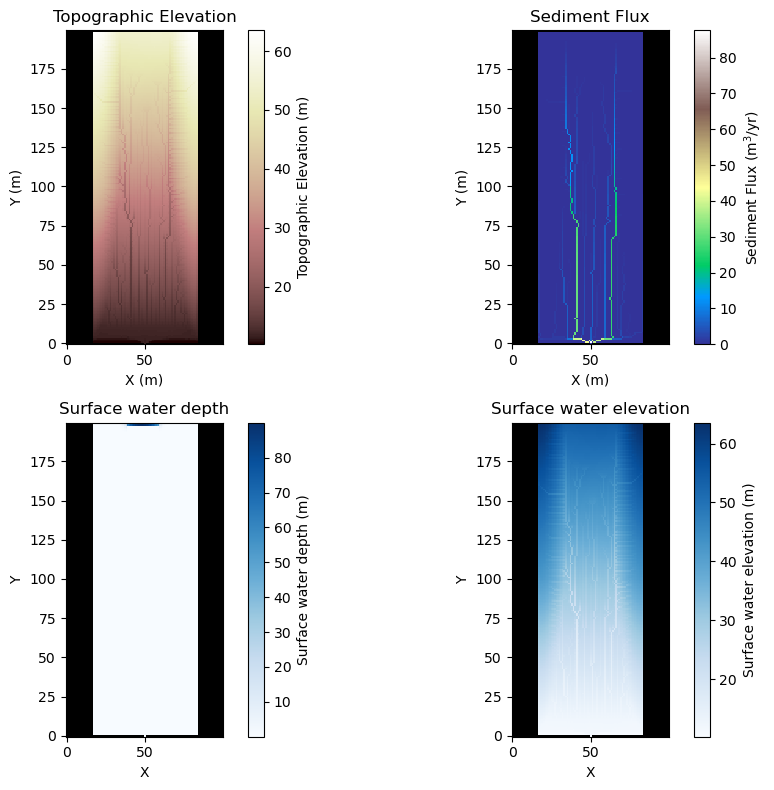

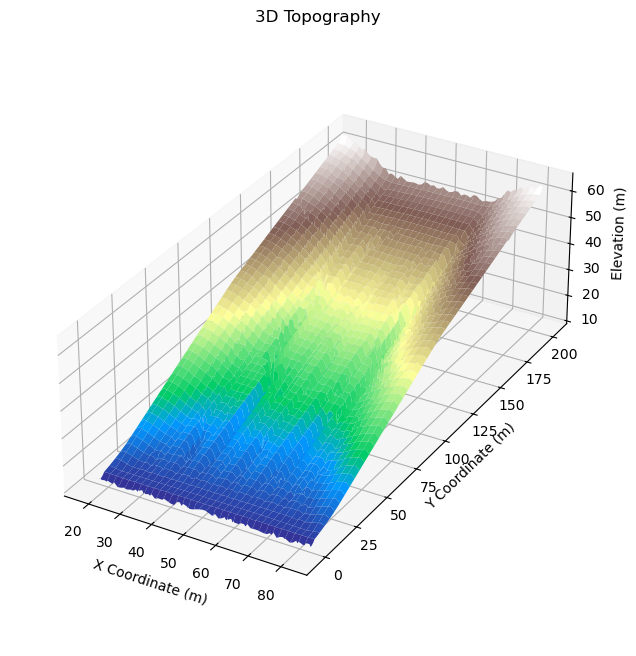

In [ ]:

# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Plot topographic elevation in the first subplot
plt.sca(axes[0,0])  # Set the current axis to the first subplot
imshow_grid(
    grid,
    "topographic__elevation",
    plot_name="Topographic Elevation",
    var_name="Topographic Elevation",
    var_units="m",
    grid_units=("m", "m"),
    color_for_closed='black',
)

# Plot sediment flux in the second subplot
plt.sca(axes[0,1])  # Set the current axis to the second subplot
imshow_grid(
    grid,
    "sediment__flux",
    plot_name="Sediment Flux",
    var_name="Sediment Flux",
    var_units=r"m$^3$/yr",
    grid_units=("m", "m"),
    cmap="terrain",
)

plt.sca(axes[1,0])  # Set the current axis to the third subplot
imshow_grid(
    grid,
    'surface_water__depth',
    plot_name="Surface water depth",
    var_name="Surface water depth",
    cmap="Blues",
    var_units="m",
)
plt.sca(axes[1,1])  # Set the current axis to the third subplot
imshow_grid(
    grid,
    'surface_water__elevation',
    plot_name="Surface water elevation",
    var_name="Surface water elevation",
    cmap="Blues",
    var_units="m",
)

plt.tight_layout()
plt.show()

#3D plot the topography
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(np.arange(0, size_x, spacing), np.arange(0, size_y, spacing))
Z = grid.at_node['topographic__elevation'].reshape(size_y, size_x)

# Limit the x domain from 33.33 to 66.67
x_mask = (X[0, :] >= 16.67) & (X[0, :] <= 83.33)
X = X[:, x_mask]
Y = Y[:, x_mask]
Z = Z[:, x_mask]
ax.set_box_aspect((1, size_y/size_x, grid.at_node['topographic__elevation'].max()/size_x))  # Aspect ratio is 1:1:0.5
ax.plot_surface(X, Y, Z, cmap='terrain', edgecolor='none')
ax.set_xlabel('X Coordinate (m)')
ax.set_ylabel('Y Coordinate (m)')
ax.set_zlabel('Elevation (m)')
ax.set_title('Resultinmg Topography in 3D')
plt.show()

#### Plot a quantification of sediment flux and deposition in profile

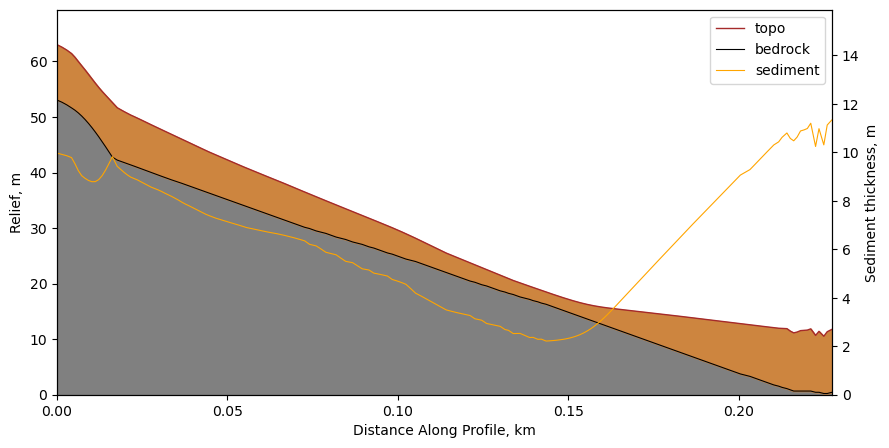

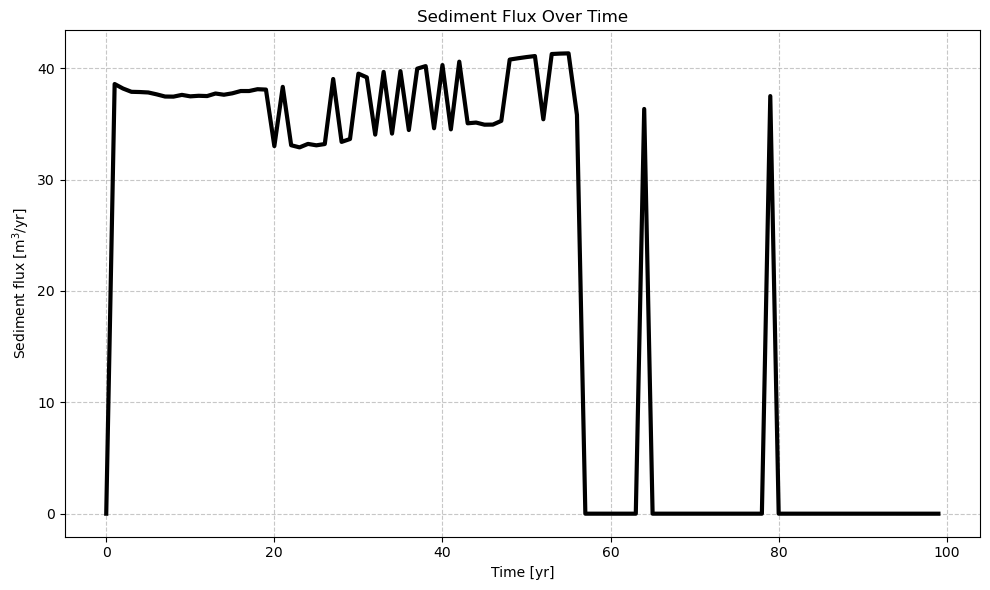

In [20]:
# Profiles with sediment
profiler = ChannelProfiler(grid)
profiler.run_one_step()
fig, ax1 = plt.subplots(figsize=(10,5))
riv_nodes = profiler.nodes
grid.at_node["bedrock_elevation"]=grid.at_node["topographic__elevation"]-grid.at_node["soil__depth"]
 
dist_atNodes=profiler.distance_along_profile[0]
el = grid.at_node["topographic__elevation"][riv_nodes]
sd = grid.at_node["soil__depth"][riv_nodes]
br = el- sd

 # Use ravel() to flatten el and br to 1D
el = el.ravel()
sd = sd.ravel()
br = br.ravel()
 
 # Calculate minimum elevation and relief
min_elevation = min(np.min(el), np.min(br), 0)
el_relief = el - min_elevation
br_relief = br - min_elevation
 
qs = grid.at_node["sediment__flux"][riv_nodes]
qs[np.where(qs<10)] = np.nan
 
plt_fontsize =10
 
#fig, ax1 = plt.subplots(figsize=(5,3.7), dpi=400)
ax2 = ax1.twinx()
dist = (max(dist_atNodes)-dist_atNodes)*1e-3
 
brown_c = [205/255,133/255,63/255]
 
# Fill the entire area from max relief to 0
#ax1.fill_between(dist, np.max(el_relief), 0, color='lightgrey', label='total area')
 
# Fill the bedrtock and colluvial material relief
ax1.fill_between(dist, br_relief, 0, color='grey', label='bedrock')
ax1.fill_between(dist, el_relief, br_relief, color=brown_c, label='colluvial material')        
 
 # Plot bedrock and topographic relief
lns2 = ax1.plot(dist, br_relief, color='k', label='bedrock', linewidth=0.8, zorder=3)
lns1 = ax1.plot(dist, el_relief, color='brown', label='topo', linewidth=1, zorder=4)
 
 # set up labels
ax1.set_xlabel('Distance Along Profile, km', fontweight='normal', fontsize=plt_fontsize)
ax1.tick_params(labelsize=plt_fontsize)
ax1.set_ylabel('Relief, m', fontweight='normal', fontsize=plt_fontsize)
ax1.set_ylim((0, np.max(el_relief)*1.1))
 
 # plot sediment thickness
lns3 = ax2.plot(dist, sd, color='orange', label ='sediment', linewidth=0.8)
ax2.set_ylabel('Sediment thickness, m', fontweight='normal', fontsize=plt_fontsize)
ax2.set_ylim((0, np.nanmax(sd) * 1.4))
ax2.set_xlim((0, dist[2]))
ax2.tick_params(labelsize=plt_fontsize)
 
 # Merge legends
lns = lns1 + lns2 + lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, fontsize=plt_fontsize)

# Set y-axis to start from 0
ax1.set_ylim(bottom=0)
plt.show()

# Instantiate figure
fig = plt.figure(figsize=(10, 6))

# Instantiate subplot
sedfluxplot = plt.subplot()

# Create time array based on actual model timesteps
# Since you're using timestep=50 and have 10 points, create proper x-axis
time_values = np.arange(0, run_time, timestep)  # [0, 50, 100, 150, ..., 450]

# Plot data - now x and y will have the same length (10 elements)
sedfluxplot.plot(time_values, sed_flux, color="k", linewidth=3.0)

# Add axis labels
sedfluxplot.set_xlabel("Time [yr]")
sedfluxplot.set_ylabel(r"Sediment flux [m$^3$/yr]")

# Add grid for better readability
sedfluxplot.grid(True, linestyle='--', alpha=0.7)

# Add a title
sedfluxplot.set_title("Sediment Flux Over Time")

# Display the plot
plt.tight_layout()
plt.show()

## Step IV. Vegetation and Erodibility
As glacier retreats, a landscape may experience revegetation (based on local climate). Vegetation then plays a role in slablizing slopes against erosion. This section explores a slope-dependent vegetation diffusion scheme.

#### Define variables and functions

In [25]:
# k_sed = grid.add_ones("sediment_erodibility", at = "node")
slope = np.rad2deg(grid.calc_slope_at_node(elevs=grid.at_node['topographic__elevation'])) 
def calc_colonization_rate(slope):
    """ Function to reduce colonization rate on higher slopes. """
    max_slope = 20  # Maximum slope (in degrees)
    if slope > max_slope:
        return 0.01  # Very low colonization on steep slopes
    else:
        return 0.1  # Normal colonization rate
    if grid_at.node["surface_water__depth"] < 0.1:
        return 0.1
    else:
        return 0
    
# 2. Vegetation field (0 = bare, 1 = vegetated)
veg = grid.add_zeros('node', 'vegetation__state', dtype=int)
veg[grid.node_y < 5] = 1  # seed bottom 5 rows with vegetation
# Define erodibility values
def calc_erodibility(veg):
    """ Function to return erodibility based on vegetation state. """
    # High erodibility for non-vegetated cells and low erodibility for vegetated cells
    if veg == 1:
        return 0.005  # Lower erodibility for vegetated cells
    else:
        return 0.01  # Higher erodibility for non-vegetated cells
    
# 3. Parameters
d = 0.01  # disturbance probability
n_steps = 200

# 4. Define update function
def vegetation_ca_step(grid, veg, d, slope):
    new_veg = veg.copy()
    for node in grid.core_nodes:
        neighbors = grid.adjacent_nodes_at_node[node]
        if veg[node] == 0:
            # Calculate slope-based colonization rate
            # slope = np.rad2deg(grid.calc_slope_at_node(elevs=elev))  # For simplicity, you can use elevation directly for slope
            c = calc_colonization_rate(slope[node])
            # Colonization from neighbors
            if any(veg[n] == 1 for n in neighbors if n != -1):
                if np.random.rand() < c:
                    new_veg[node] = 1
        elif veg[node] == 1:
            # Disturbance/death
            if np.random.rand() < d:
                new_veg[node] = 0
    veg[:] = new_veg  # update in-place
    


c:\Users\ahkoe\miniforge3\envs\ivy\Lib\site-packages\landlab\field\graph_field.py:1347: FutureWarning: Calling `add_empty` with the field location as the first argument is deprecated and will be removed in future versions. Instead, please use the `at` keyword to specify the location: add_empty(arg0, at='node').
  data = self.add_empty(*args, **kwds)


#### Run vegetation-erosion model showing final vegetation condition

In [ ]:
# 5. Time loop with plot every 10 steps
for t in range(0, n_steps + 1, 10):
    for _ in range(100):
        vegetation_ca_step(grid, veg, d, slope)
    #hsd = grid.calc_hillshade_at_node(alt=45.0, az=315.0, slp=None, asp=None, unit='degrees', elevs='topographic__elevation')
    #plt.figure(figsize=(8, 6))
    #grid.imshow(hsd, cmap='gray')
    #plt.hold(True)
    plt.imshow(grid.node_vector_to_raster(veg), cmap='Greens', origin='lower')
    plt.title(f"Vegetation CA (Time step = {t})")
    plt.colorbar(label="Vegetation state")
    # Annotate front row
    raster = grid.node_vector_to_raster(veg)
    rows_with_veg = np.where(np.any(raster > 0, axis=1))[0]
    
if len(rows_with_veg) > 0:
    front_row = rows_with_veg[-1]
    plt.axhline(front_row, color='red', linestyle='--')
    plt.text(1, front_row + 1, f"Front ~ row {front_row}", color='red')
plt.tight_layout()
plt.show()

## Step V. Combining the Elements into a Scaled Model
<div>
<img src="Kviarjokull.PNG" width="600" hspace="20">
</div>
Kviarjokull System in Southeast Iceland


#### Define grid using natural topography and plot current state

Text(0.5, 1.0, 'Hollshade')

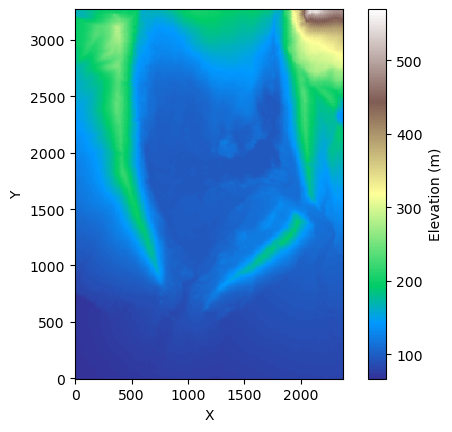

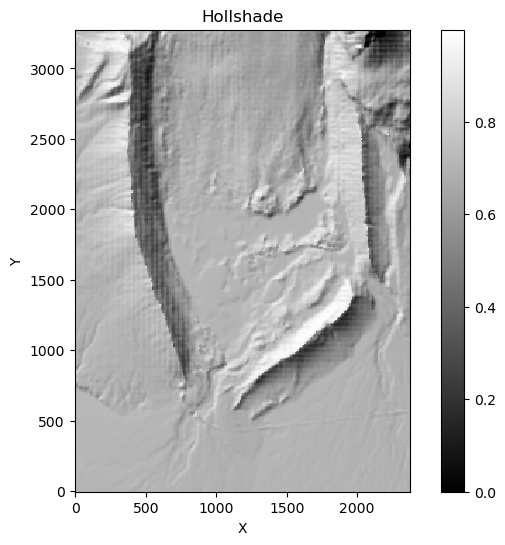

In [ ]:

file_path = './Kviarjokull_rotate_8_831m.csv'

# Read the CSV file
data = pd.read_csv(file_path, header=None)
spacing = 8.8 #meters
size_x = len(data.columns)
size_y = len(data.index)
grid = RasterModelGrid((size_y, size_x), xy_spacing=spacing)
elev = grid.add_zeros('topographic__elevation', at='node')
# Assign the elevation data to the grid
elev[:] = data.iloc[::-1, ::].values.flatten()
grid.imshow(elev, cmap='terrain', colorbar_label='Elevation (m)')


# Add subsurface ice within terrain between 150 & 400 m elevation
#ice = grid.add_zeros('ice__thickness', at='node')
#ice[grid.core_nodes] = np.random.rand(len(grid.core_nodes)) * 2.0  # Random ice thickness

#swd = grid.add_zeros('surface_water__depth', at='node')
#swd[grid.core_nodes] = np.random.rand(len(grid.core_nodes)) * 0.1  # Initial surface water depth

hsd = grid.calc_hillshade_at_node(alt=45.0, az=315.0, slp=None, asp=None, unit='degrees', elevs='topographic__elevation')
plt.figure(figsize=(8, 6))
grid.imshow(hsd, cmap='gray')
plt.title('Hillshade')

slope = np.rad2deg(grid.calc_slope_at_node(elevs='topographic__elevation'))
plt.figure(figsize=(8, 6))
grid.imshow(slope, cmap='gray')
plt.title('Slope')

#### Initialize Functions

In [ ]:
# Set up timing
run_time = 100000 #change this value to the real one
timestep = 100 #change this value to the real one

# Add overland flow parameters to lowest 10% of upstream elevations in penultimate row
num_nodes = size_x * size_y / spacing - 1
top_row = grid.nodes_at_top_edge
penultimate_row = np.arange(top_row[1] - 1 - len(top_row), top_row[1] - 1, 1)
penultimate_elevs = grid.at_node["topographic__elevation"][penultimate_row]
inlet_threshold = np.percentile(penultimate_elevs, 10)
below_threshold_nodes = []
for i, index  in enumerate(penultimate_row):
    if penultimate_elevs[i] < inlet_threshold:
        below_threshold_nodes.append(int(index))

# Water velocity is zero in everywhere since there is no water yet
vel = grid.add_zeros("surface_water__velocity", at="link", clobber=True)

# Calculating the initial water surface elevation from water depth and topographic elevation
wse = grid.add_field("surface_water__elevation", grid.at_node['topographic__elevation'], at="node", clobber=True)

# Initialize components
diffuser = LinearDiffuser(grid, linear_diffusivity=0.01)
overland_flow = OverlandFlow(grid, steep_slopes = True)
flow_director = FlowDirectorSteepest(grid)
flow_accumulator = FlowAccumulator(grid)
sed_dep_eroder = SedDepEroder(grid, K_sp=0.01, m_sp=0.5, n_sp=1.0)

# Give the downward component of each inlet node an initial discharge corresponding to constant_Q
constant_Q = 60. # discharge value; m3/s (PLAY WITH THIS VALUE!!)
Q_array = np.ones(len(below_threshold_nodes)) * constant_Q
mannings_n = 0.05 # Mannings roughness
for n in below_threshold_nodes:
    links = grid.links_at_node[n]  #links pointing down
    print(links)
    grid.at_link["surface_water__discharge"][links[3]] = constant_Q

# Set up the discharge as a function of time
discharge_list = np.arange(constant_Q, 0.556*run_time + constant_Q, 0.556*timestep)

#### LOOP THROUGH MORPHODYNAMIC FUNCTIONS HERE:

In [ ]:
for t in range(100):  # Simulate 100 time steps
    # Simulate overland flow
    overland_flow.run_one_step()
    
    # Direct and accumulate flow
    flow_director.run_one_step()
    flow_accumulator.run_one_step()
    
    # Erode and deposit sediment
    sed_dep_eroder.run_one_step(dt=1.0)
    
    # Diffuse the landscape
    diffuser.run_one_step(dt=1.0)
    
    # Melt ice and adjust topography
    melt_rate = 10  # Example melt rate
    ice_melt = np.minimum(ice[grid.core_nodes], melt_rate)
    ice[grid.core_nodes] -= ice_melt
    elev[grid.core_nodes] -= ice_melt


#### Plot the final topography and sediment flux through time

Text(0.5, 1.0, 'Final Topography')

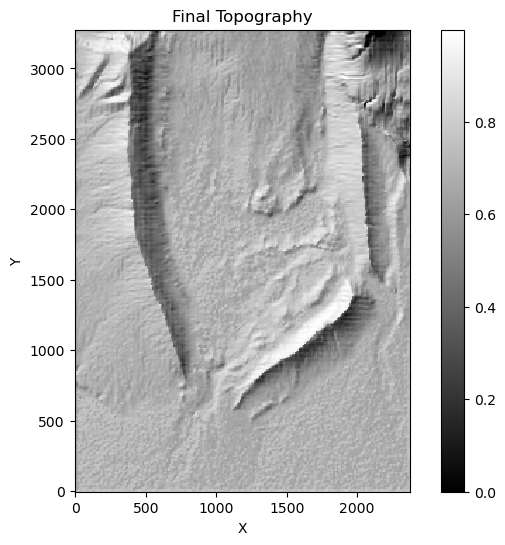

In [ ]:

hsd = grid.calc_hillshade_at_node(alt=45.0, az=315.0, slp=None, asp=None, unit='degrees', elevs='topographic__elevation')
plt.figure(figsize=(8, 6))
grid.imshow(hsd, cmap='gray')
plt.title('Final Topography')

# Profiles with sediment
profiler = ChannelProfiler(grid)
profiler.run_one_step()
fig, ax1 = plt.subplots(figsize=(10,5))
riv_nodes = profiler.nodes
grid.at_node["bedrock_elevation"]=grid.at_node["topographic__elevation"]-grid.at_node["soil__depth"]
 
dist_atNodes=profiler.distance_along_profile[0]
el = grid.at_node["topographic__elevation"][riv_nodes]
sd = grid.at_node["soil__depth"][riv_nodes]
br = el- sd

 # Use ravel() to flatten el and br to 1D
el = el.ravel()
sd = sd.ravel()
br = br.ravel()
 
 # Calculate minimum elevation and relief
min_elevation = min(np.min(el), np.min(br), 0)
el_relief = el - min_elevation
br_relief = br - min_elevation
 
qs = grid.at_node["sediment__flux"][riv_nodes]
qs[np.where(qs<10)] = np.nan
 
plt_fontsize =10
 
#fig, ax1 = plt.subplots(figsize=(5,3.7), dpi=400)
ax2 = ax1.twinx()
dist = (max(dist_atNodes)-dist_atNodes)*1e-3
 
brown_c = [205/255,133/255,63/255]
 
# Fill the entire area from max relief to 0
#ax1.fill_between(dist, np.max(el_relief), 0, color='lightgrey', label='total area')
 
# Fill the bedrtock and colluvial material relief
ax1.fill_between(dist, br_relief, 0, color='grey', label='bedrock')
ax1.fill_between(dist, el_relief, br_relief, color=brown_c, label='colluvial material')        
 
 # Plot bedrock and topographic relief
lns2 = ax1.plot(dist, br_relief, color='k', label='bedrock', linewidth=0.8, zorder=3)
lns1 = ax1.plot(dist, el_relief, color='brown', label='topo', linewidth=1, zorder=4)
 
 # set up labels
ax1.set_xlabel('Distance Along Profile, km', fontweight='normal', fontsize=plt_fontsize)
ax1.tick_params(labelsize=plt_fontsize)
ax1.set_ylabel('Relief, m', fontweight='normal', fontsize=plt_fontsize)
ax1.set_ylim((0, np.max(el_relief)*1.1))
 
 # plot sediment thickness
lns3 = ax2.plot(dist, sd, color='orange', label ='sediment', linewidth=0.8)
ax2.set_ylabel('Sediment thickness, m', fontweight='normal', fontsize=plt_fontsize)
ax2.set_ylim((0, np.nanmax(sd) * 1.4))
ax2.set_xlim((0, dist[2]))
ax2.tick_params(labelsize=plt_fontsize)
 
 # Merge legends
lns = lns1 + lns2 + lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, fontsize=plt_fontsize)

# Set y-axis to start from 0
ax1.set_ylim(bottom=0)
plt.show()

# Instantiate figure
fig = plt.figure(figsize=(10, 6))

# Instantiate subplot
sedfluxplot = plt.subplot()

# Create time array based on actual model timesteps
# Since you're using timestep=50 and have 10 points, create proper x-axis
time_values = np.arange(0, run_time, timestep)  # [0, 50, 100, 150, ..., 450]

# Plot data - now x and y will have the same length (10 elements)
sedfluxplot.plot(time_values, sed_flux, color="k", linewidth=3.0)

# Add axis labels
sedfluxplot.set_xlabel("Time [yr]")
sedfluxplot.set_ylabel(r"Sediment flux [m$^3$/yr]")

# Add grid for better readability
sedfluxplot.grid(True, linestyle='--', alpha=0.7)

# Add a title
sedfluxplot.set_title("Sediment Flux Over Time")

# Display the plot
plt.tight_layout()
plt.show()

## Summary

This document forms a simple basis, or starting point, for upscaling these results to a natural system in an arctic or alpine deglaciated valley.

### References

    Brook, M. S., & Paine, S. (2012). Ablation of ice‐cored moraine in a humid, maritime climate: Fox Glacier, New Zealand. Geografiska Annaler: Series A, Physical Geography, 94(3), 339-349.

    Church, M., & Ryder, J. M. (1972). Paraglacial sedimentation: a consideration of fluvial processes conditioned by glaciation. Geological Society of America Bulletin, 83(10), 3059-3072.
    
    Nicholson, L., & Benn, D. I. (2006). Calculating ice melt beneath a debris layer using meteorological data. Journal of Glaciology, 52(178), 463-470. https://doi.org/10.3189/172756506781828584

    Østrem, G. (1959). Ice melting under a thin layer of moraine, and the existence of ice cores in moraine ridges. Geografiska Annaler, 41(4), 228-230. https://www.jstor.org/stable/4626805

    Richardson, S. D., & Reynolds, J. M. (2000). Degradation of ice-cored moraine dams: implications for hazard development. IAHS PUBLICATION, 187-198.

    Schomacker, A., & Kjær, K. H. (2008). Quantification of dead‐ice melting in ice‐cored moraines at the high‐Arctic glacier Holmströmbreen, Svalbard. Boreas, 37(2), 211-225.

    Sletten, K., Lyså, A., & Lønne, I. (2001). Formation and disintegration of a high‐arctic ice‐cored moraine complex, Scott Turnerbreen, Svalbard. Boreas, 30(4), 272-284.https://doi.org/10.1111/j.1502-3885.2001.tb01046.x

    Westoby, M. J., Glasser, N. F., Brasington, J., Hambrey, M. J., Quincey, D. J., & Reynolds, J. M. (2014). Modelling outburst floods from moraine-dammed glacial lakes. Earth-Science Reviews, 134, 137-159. https://doi.org/10.1016/j.earscirev.2014.03.009

    van Woerkom, T., Steiner, J. F., Kraaijenbrink, P. D., Miles, E. S., & Immerzeel, W. W. (2019). Sediment supply from lateral moraines to a debris-covered glacier in the Himalaya. Earth Surface Dynamics, 7(2), 411-427. https://doi.org/10.5194/esurf-7-411-2019